Imports:

In [38]:
import requests
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

1. Load a corpus of text (ideally several documents, not too long, with interesting language)

In [34]:
# Load INAUGURAL ADDRESSES OF THE PRESIDENTS OF THE UNITED STATES from 1789 to 2005
url = "https://www.gutenberg.org/files/925/925-h/925-h.htm"
response = requests.get(url)
html_text = response.text

# Strip HTML tags
soup = BeautifulSoup(html_text, 'html.parser')
text = soup.get_text()

# Find the actual start of speeches (skip preamble)
start_index = text.find("GEORGE WASHINGTON, FIRST INAUGURAL ADDRESS")
text = text[start_index:]  # slice out table of contents and intro fluff

# Split into title-body chunks
# Each true speech usually starts with a full-caps name + "INAUGURAL ADDRESS"
split_blocks = re.split(r'\n\s*([A-Z .,]+INAUGURAL ADDRESS)\s*\n', text)

# Extract (title, body) pairs
titles = split_blocks[1::2]
bodies = split_blocks[2::2]
speeches = [(titles[i].strip(), bodies[i].strip()) for i in range(len(titles)) if i < len(bodies)]

# Filter out non-speech artifacts (e.g. stray headers, junk)
cleaned_speeches = []
for title, body in speeches:
    if len(body.split()) > 100:  # Minimum length to count as a real speech
        cleaned_speeches.append((title, body))

# Result
print(f"✅ Loaded {len(cleaned_speeches)} real inaugural addresses (expected ≈55).\n")

# Preview a few
for i in range(3):
    print(f"--- {cleaned_speeches[i][0]} ---\n{cleaned_speeches[i][1][:500]}...\n")

✅ Loaded 55 real inaugural addresses (expected ≈55).

--- GEORGE WASHINGTON, FIRST INAUGURAL ADDRESS ---
IN THE CITY OF NEW YORK THURSDAY, APRIL 30, 1789
    


        [Transcriber's note: The Nation's first chief executive took his oath of
        office in April in New York City on the balcony of the Senate Chamber at
        Federal Hall on Wall Street. General Washington had been unanimously
        elected President by the first electoral college, and John Adams was
        elected Vice President because he received the second greatest number of
        votes. Under the rules, each elector ca...

--- GEORGE WASHINGTON, SECOND INAUGURAL ADDRESS ---
IN THE CITY OF PHILADELPHIA, MONDAY, MARCH 4, 1793
    


        [Transcriber's note: President Washington's second oath of office was
        taken in the Senate Chamber of Congress Hall in Philadelphia on March 4,
        the date fixed by the Continental Congress for inaugurations. Before an
        assembly of Congressmen, Cabinet 

2. Compute a word frequency matrix (with some not unreasonable weighting?)

In [36]:
# Custom tokenizer function to clean text:
# - Lowercases
# - Removes numbers and punctuation
# - Keeps only alphabetic words with at least 2 letters
def clean_tokenizer(text):
    tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    return tokens

# Create the TF-IDF vectorizer with cleaning:
# - Uses the custom tokenizer above
# - Removes common English stop words
# - Ignores very common words (max_df)
# - Ignores rare words (min_df)
vectorizer = TfidfVectorizer(
    tokenizer=clean_tokenizer,
    stop_words='english',
    max_df=0.95,
    min_df=2
)

# Extract just the speech bodies (no titles)
docs = [body for _, body in cleaned_speeches]

# Build the term-document matrix
X = vectorizer.fit_transform(docs)  # shape: (n_docs, n_terms)

# Transpose to get shape: (terms x docs)
term_doc_matrix = X.T.toarray()

# Extract the actual terms (features)
terms = vectorizer.get_feature_names_out()

# Confirm results
print(f"✅ Cleaned Term-document matrix shape: {term_doc_matrix.shape}")
print(f"🔤 Sample terms: {terms[:10]}")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


✅ Cleaned Term-document matrix shape: (4991, 55)
🔤 Sample terms: ['abandon' 'abandoned' 'abandonment' 'abide' 'abiding' 'abilities'
 'ability' 'able' 'abolish' 'abolished']


3. Compute the SVD of this matrix.

In [37]:
# Perform SVD on the term-document matrix
U, S, VT = svd(term_doc_matrix, full_matrices=False)

print(f"✅ SVD complete!")
print(f"U shape: {U.shape}")     # word vectors
print(f"Σ shape: {S.shape}")     # singular values
print(f"V^T shape: {VT.shape}")  # document vectors (transposed)

✅ SVD complete!
U shape: (4991, 55)
Σ shape: (55,)
V^T shape: (55, 55)


4. Perform LSA = Latent Semantic Analysis on the corpus

In [39]:
# Choose number of latent dimensions (topics/themes)
k = 10

# Truncate U, S, V^T
U_k = U[:, :k]
S_k = np.diag(S[:k])
VT_k = VT[:k, :]

# Reduced approximation of A
A_k = U_k @ S_k @ VT_k

print(f"✅ LSA completed with k={k} latent dimensions.")
print(f"Reduced matrix shape: {A_k.shape}")

✅ LSA completed with k=10 latent dimensions.
Reduced matrix shape: (4991, 55)


5. Show off the results somehow

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128220 (\N{SCROLL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


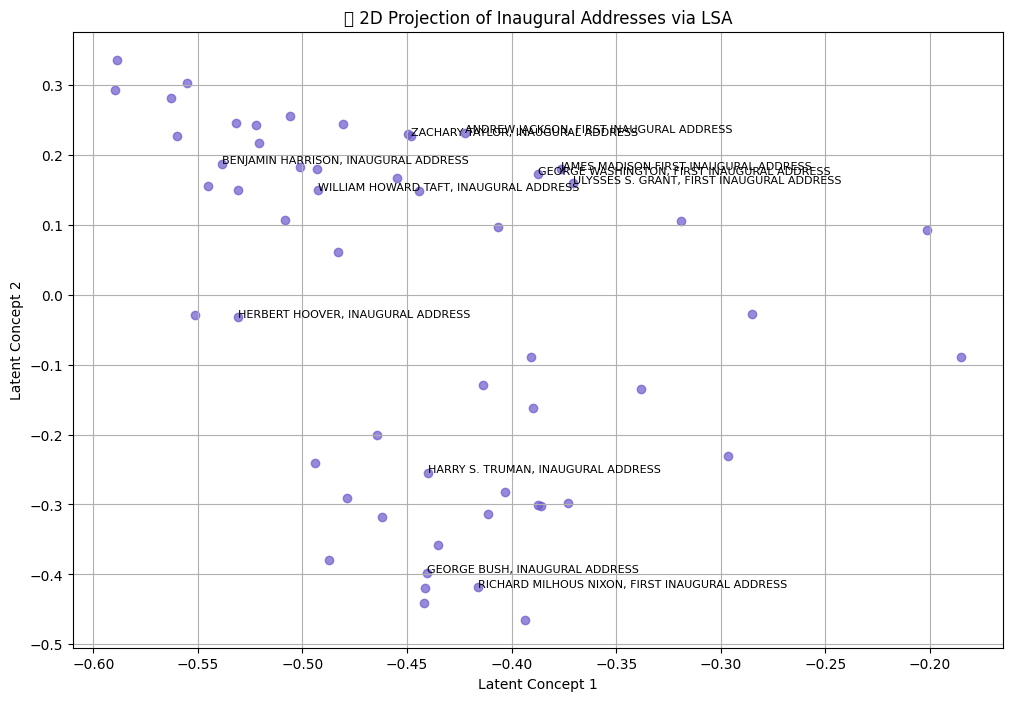


🧠 Top words per latent theme:

🧭 Theme 1
Top words: concentrated, interpreted, tolerant, mail, main, sentence, obtaining, notice, warms, solicitation 

🧭 Theme 2
Top words: states, constitution, public, union, government, country, interests, foreign, revenue, state 

🧭 Theme 3
Top words: business, conditions, economic, law, industrial, enforcement, tariff, laws, leadership, international 

🧭 Theme 4
Top words: war, nations, peoples, peace, men, life, british, counsel, principles, free 

🧭 Theme 5
Top words: war, shall, god, let, congress, south, answered, offense, law, wills 

🧭 Theme 6
Top words: shall, philadelphia, president, address, things, learned, men, congress, willingly, violated 

🧭 Theme 7
Top words: union, states, democracy, constitution, nation, men, years, change, slavery, things 

🧭 Theme 8
Top words: war, america, gutenberg, project, british, nation, united, new, spirit, naval 

🧭 Theme 9
Top words: gutenberg, project, works, philadelphia, democracy, agreement, constit

In [41]:
# Project speeches into latent semantic space
# Columns of V are the documents; we apply S_k to get coordinates
doc_coords = (S_k @ VT_k).T  # shape: (n_docs, k)

# Reduce dimensionality to 2D for visualization
svd_2d = TruncatedSVD(n_components=2)
doc_coords_2d = svd_2d.fit_transform(doc_coords)

# Plot the documents in 2D space
titles = [title for title, _ in cleaned_speeches]

plt.figure(figsize=(12, 8))
plt.scatter(doc_coords_2d[:, 0], doc_coords_2d[:, 1], color='slateblue', alpha=0.7)

# Annotate some speeches for clarity
for i in range(len(titles)):
    if i % 5 == 0:  # Label every 5th speech (adjust as needed)
        plt.text(doc_coords_2d[i, 0], doc_coords_2d[i, 1], titles[i], fontsize=8)

plt.title("📜 2D Projection of Inaugural Addresses via LSA")
plt.xlabel("Latent Concept 1")
plt.ylabel("Latent Concept 2")
plt.grid(True)
plt.show()

# Explore the themes (latent dimensions)
# Each column in U_k corresponds to a latent theme (topic)
print("\n🧠 Top words per latent theme:\n")

for topic in range(k):
    print(f"🧭 Theme {topic + 1}")
    top_indices = np.argsort(-U_k[:, topic])[:10]  # top 10 contributing words
    top_words = [terms[i] for i in top_indices]
    print("Top words:", ", ".join(top_words), "\n")

The 2D plot reveals a semantic landscape of U.S. presidential inaugural addresses, where each point represents a speech projected into a space defined by its dominant themes. Clusters indicate groups of speeches sharing similar rhetorical concerns — such as foundational governance, economic policy, or wartime language — while outliers signal unique tones or historical moments. Themes like "Civil War & Religious Appeals" and "Democracy, Union, and Slavery" show how presidents have addressed national crises and social change. Meanwhile, denser regions suggest continuity in constitutional and democratic ideals across administrations. The visualization thus captures both the evolution and recurrence of core American values over time.

From the LSA, we also determine the top words associated with each latent theme. We can now use these words to come up with generalize themes for each latent theme:

Theme 1: Formal / Rhetorical Structure  
Theme 2: Foundational Government Principles  
Theme 3: Economic & Industrial Policy  
Theme 4: War, Peace, and Foreign Affairs  
Theme 5: Civil War & Religious Appeals  
Theme 6: Enlightenment & Early Republic  
Theme 7: Democracy, Union, and Slavery  
Theme 8: Revolution & National Identity  
Theme 9: Democratic Foundations (some noise)  
Theme 10: Monetary Rhetoric (some noise)  